In [1]:
import tensorflow as tf
import os

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
gpus=tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [4]:
import numpy as numpy
import matplotlib.pyplot as plt
import os

In [5]:
data=tf.keras.utils.image_dataset_from_directory('data')

Found 4000 files belonging to 8 classes.


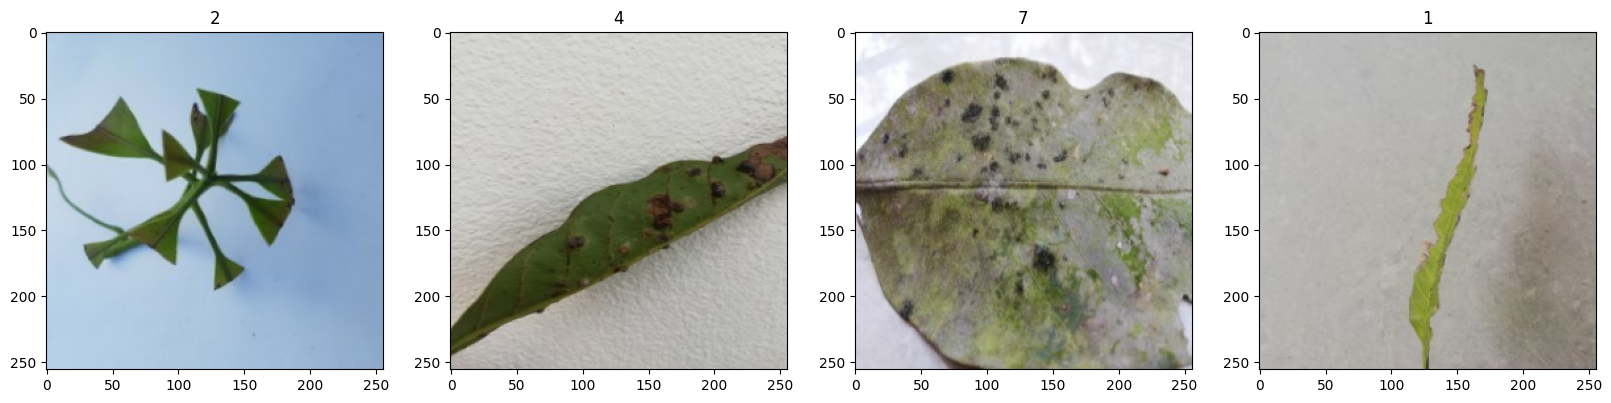

In [6]:
data_iterator = data.as_numpy_iterator()
batch = data_iterator.next()
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

The tensorflow image dataset from directory loads each directory images into a different class, which is desired for us as well. It assings the classes by alphanumeric order of directory names. To see which class refers to which number we can do the following:

In [7]:
class_names = data.class_names
for i in range(len(class_names)):
    print(f'The {i}th class name is: {class_names[i]}')

The 0th class name is: Anthracnose
The 1th class name is: Bacterial Canker
The 2th class name is: Cutting Weevil
The 3th class name is: Die Back
The 4th class name is: Gall Midge
The 5th class name is: Healthy
The 6th class name is: Powdery Mildew
The 7th class name is: Sooty Mould


In [8]:
#Scale our data as images contains 0-255 values
#Luckily the tensorflow image dataset load method includes map method as well
scale_data=data.map(lambda x,y: (x/255,y))
img_shape=data.element_spec[0].shape[1:]
class_count=len(data.class_names)

## Creating train, validation and test groups

In [9]:
len(data)

125

Our data has 125 batches. We will use %70 train %20 validation and %10 test split.

In [10]:
train_split=int(len(data)*.7)
validation_split=int(len(data)*.2)
test_split=len(data)-train_split-validation_split

In [11]:
#Check total batch numbers in splits and if our total split batch number equals back to 125:
print(train_split)
print(validation_split)
print(test_split)
print(train_split+validation_split+test_split)

87
25
13
125


In [12]:
#And now lets assign data batches to groups:
train=scale_data.take(train_split)
validation=scale_data.skip(train_split).take(validation_split)
test=scale_data.skip(train_split+validation_split).take(test_split)

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers

In [15]:
# create pre-trained model (you can built on pretrained model such as :  efficientnet, VGG , Resnet )
# we will use efficientnetb3 from EfficientNet family.
base_model = tf.keras.applications.MobileNetV2(include_top= False, weights= "imagenet", input_shape= img_shape, pooling= 'max')
# base_model.trainable = False

In [22]:
model = Sequential([
    base_model,
    BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
    Dense(256, kernel_regularizer= regularizers.l2(l= 0.016), activity_regularizer= regularizers.l1(0.006),
                bias_regularizer= regularizers.l1(0.006), activation= 'relu'),
    Dropout(rate= 0.45, seed= 123),
    Dense(8, activation= 'softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 1280)             2257984   
 ional)                                                          
                                                                 
 batch_normalization (BatchN  (None, 1280)             5120      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 256)               327936    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 8)                 2056      
                                                                 
Total params: 2,593,096
Trainable params: 2,556,424
Non-

In [18]:
logdir='logs'

In [19]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [20]:
hist = model.fit(train, epochs=4, validation_data=validation, callbacks=[tensorboard_callback])

Epoch 1/4
87/87 [==============================] - 52s 365ms/step - loss: 5.9759 - accuracy: 0.9019 - val_loss: 8.1135 - val_accuracy: 0.2250
Epoch 2/4
87/87 [==============================] - 32s 361ms/step - loss: 2.2906 - accuracy: 0.9842 - val_loss: 3.5870 - val_accuracy: 0.2338
Epoch 3/4
87/87 [==============================] - 31s 349ms/step - loss: 0.8786 - accuracy: 0.9932 - val_loss: 3.7309 - val_accuracy: 0.1425
Epoch 4/4
87/87 [==============================] - 31s 348ms/step - loss: 0.4242 - accuracy: 0.9975 - val_loss: 2.3266 - val_accuracy: 0.2313


In [21]:
loss, accuracy = model.evaluate(test)
print(f'Test loss: {loss}')
print(f'Test accuracy: {accuracy}')

13/13 [==============================] - 16s 46ms/step - loss: 2.3446 - accuracy: 0.2091
Test loss: 2.3445897102355957
Test accuracy: 0.20913460850715637


Second Run with MobileNet

In [23]:
model = Sequential([
    base_model,
    BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
    Dense(256, kernel_regularizer= regularizers.l2(l= 0.016), activity_regularizer= regularizers.l1(0.006),
                bias_regularizer= regularizers.l1(0.006), activation= 'relu'),
    Dropout(rate= 0.45),
    Dense(32, kernel_regularizer= regularizers.l2(l= 0.016), activity_regularizer= regularizers.l1(0.006),
                bias_regularizer= regularizers.l1(0.006), activation= 'relu'),
    Dropout(rate= 0.45),
    Dense(8, activation= 'softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()
hist = model.fit(train, epochs=4, validation_data=validation, callbacks=[tensorboard_callback])

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 1280)             2257984   
 ional)                                                          
                                                                 
 batch_normalization_2 (Batc  (None, 1280)             5120      
 hNormalization)                                                 
                                                                 
 dense_5 (Dense)             (None, 256)               327936    
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_6 (Dense)             (None, 32)                8224      
                                                                 
 dropout_3 (Dropout)         (None, 32)               